# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some or all of which may be offensive.*

# Midterm review 

~5 True/False, ~6 short answer
 
**Topics:** 
- Twitter API 
 - what comes in a tweet? 
 - how do rate limits work? 
 - can you understand API documentation? 
- graph basics: 
 - directed/undirected 
 - path 
 - cycle 
 - connected 
 - connected component 
 - degree (distribution) 
 - diameter 
 - average path length 
 - clustering coefficient 
- modeling networks 
 - random graphs 
 - regular graphs 
 - rewired graphs 
 - what makes a small world? 
- community detection 
 - girvan-newman (betweenness) 
 - graph cuts 
 - representing graphs with matrices 
 - graph laplacian 
- link prediction 
 - shortest path 
 - common neighbors 
 - jaccard 
 - preferential attachment 
 - sim rank 
 - evaluation 
- information cascades 
 - urn experiment 
 - bayes' theorem for decision making 
 - game-theoretic model 
 - maximizing payoff 
	- cluster density 
- sentiment analysis 
 - lexicon approach 
 - machine learning 
 
**Question types:** 
- What does this algorithm output? 
 - E.g., what is jaccard score for a specific link? 
 - E.g., what is the next step in girvan-newman? 
- What does this code do? 
 - E.g., I give you a new graph-generating algorithm, tell me what it produces 
- Write a new algorithm 
 - E.g., provide pseudo-code the linear-threshold cascade model 
- True/False 
 - E.g., small world graphs have higher clustering coefficients than random graphs.

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?


# Two Approaches

- Lexicons (word lists)

- Machine learning

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: http://neuro.imm.dtu.dk/wiki/AFINN


In [24]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), 
                                          str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


In [25]:
len(afinn)

2462

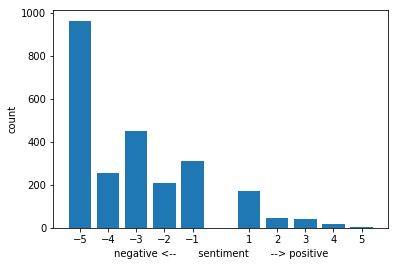

In [26]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('negative <--       sentiment       --> positive')
plt.ylabel('count')
plt.show()

In [28]:
# How do we score a document?
def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print('\t%s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	scam=-2
	broken=-1
AFINN:  -3.0


In [29]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both too good and bad".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	good=3
	bad=-3
AFINN:  0.0


In [30]:
# Distinguish neutral from pos/neg.
# Return two scores per document.
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t%s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	good=3
	bad=-3
AFINN: (3, 3)


In [31]:
doc = "the plot is not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	bad=-3
AFINN: (0, 3)


In [32]:
import configparser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets',
                         {'q': 'mcdonalds', 'count': 100}):
    tweets.append(r)

In [33]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [41]:
# Tokenize tweets
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[6]['text'], tokens[10]))
#tweets[50]['user']['name']
# tweets[50]['user']['screen_name']

tokenized, e.g., 
@McDonalds those are some pricey pickles. To bad I didn’t get the nuggets I ordered. #Fail https://t.co/fs36ggP2mN
to
['rt', 'tanzverbotcf', 'grüße', 'vom', 'mcdonalds', 'https', 't', 'co', '4rmnubmstx']


In [42]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [44]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [45]:
len(negatives)

22

In [46]:
len(positives)

27

In [47]:
# Print top positives:
for tweet, pos, neg in sorted(positives,
                              key=lambda x: x[1],
                              reverse=True):
    print(pos, neg, tweet)

11 0 @KidbyVet Hey, Lisa! Thanks for that haiku, we loved it! Good luck! 😊
8 0 @DarkTruths16 Thanks for the entry, good luck! 💓
8 0 @bigdawgtrayy That's awesome! We hope you enjoy it all 😋
6 0 @ anyone thinking i dont love their taizo fanart, I save it and want to but Mcdonalds for myself.
6 0 Me and Grace are fighting over what sauce is better on McDonalds nuggets aren't we best friend goals
4 2 @McDonalds the fact that you called it the Grand Big Mac and not the Mac Daddy is aggressively disappointing.
4 0 Voy en un micro y casi todos van hablando de lo que paso en mcdonalds, hasta unos viejitos wow
4 0 @McDonalds My dearest Big Mac @McDonalds
My sauce of happiness. My one and only. My picklemonster. Who knew I would… https://t.co/mM5PI4yKEm
3 0 Why is mcdonalds the best food place in the Tivoli?? The food places in there are trash.
3 0 RT @PoliceCreek: This Friday! Come join us. Hope to see you there! #retweet #coffeewithacop #community #McDonalds #hcpd @McDonalds https://…
3 0 @roc

In [49]:
afinn_sentiment2(tokenize('Why is mcdonalds the best food place in the Tivoli?? The food places in there are trash.'),
                 afinn, verbose=True)

	best=3


(3, 0)

In [50]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 5 @McDonalds those are some pricey pickles. To bad I didn’t get the nuggets I ordered. #Fail https://t.co/fs36ggP2mN
0 5 RT @milesgrace77: I believe McDonalds workers deserve a living wage. Dumbass Republicans probably already scream at them for cold fries. Wh…
2 4 RT @Freedom_Daily: McDonald’s Just Pissed Off Most Of America With FOUL New Rule Effective Immediately! https://t.co/BKfjaAqQZm #MAGA https…
0 4 RT @LukeNWood: I don’t understand why McDonalds workers get so much shit from people. Just because they work at McDonald’s? And it’s been b…
1 4 I had popeye’s, mcdonalds and a huge ass cinnamon roll. I’m still hungry! #fatpeopleproblems
0 4 McDonald’s  “curbside ordering”..wtf? https://t.co/bl2B2bGc1G https://t.co/3iv6J3rAAa
0 3 RT @Dax_x98: @realDonaldTrump What Are You Going To Do When U Get Locked Up For #ObstructionOfJustice &amp; #Treason I Don't Think They Have A…
0 3 @Jas_Jennette Alert! We have a McD’s emergency! Someone grab Jasmine some McDonald's stat!
0 3 RT @foreveri

In [51]:
afinn_sentiment2(tokenize("@Wendys @McDonalds snubbed me two nuggets. What do?"),
                 afinn, verbose=True)

	snubbed=-2


(0, 2)

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

<br><br><br><br>

In [52]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(),
                       key=lambda x:x[1],
                       reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

pay count=3 sentiment=-1
better count=3 sentiment=2
big count=3 sentiment=1
good count=3 sentiment=3
best count=2 sentiment=3
hope count=2 sentiment=2
thanks count=2 sentiment=2
luck count=2 sentiment=3
want count=2 sentiment=1
no count=2 sentiment=-1
like count=2 sentiment=2


In [56]:
[t for t in tokens if 'better' in t]

[['rt',
  'heatpenis',
  'wendys',
  'is',
  'better',
  'than',
  'both',
  'burgerking',
  'and',
  'mcdonalds',
  'https',
  't',
  'co',
  'jgd9vk1dj2'],
 ['wendys',
  'is',
  'better',
  'than',
  'both',
  'burgerking',
  'and',
  'mcdonalds',
  'https',
  't',
  'co',
  'jgd9vk1dj2'],
 ['me',
  'and',
  'grace',
  'are',
  'fighting',
  'over',
  'what',
  'sauce',
  'is',
  'better',
  'on',
  'mcdonalds',
  'nuggets',
  'aren',
  't',
  'we',
  'best',
  'friend',
  'goals']]

# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**
- **Hyponym:**
  - Y is a Hyponym of X if every Y is a kind of X
    - **dog** is a hyponym of **canine**
    
<br><br><br>

<img src="https://upload.wikimedia.org/wikipedia/en/1/1f/Hyponymsandhypernyms.jpg">

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

![senti](senti.png)

[source](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf)

In [57]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
# must run nltk.download('sentiwordnet')
happy = list(swn.senti_synsets('happy', 'a'))[0]

print('happy(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (happy.neg_score(), happy.pos_score(), happy.obj_score()))

happy(a): negative_score=0.00 positive_score=0.88 objective_score=0.12


In [58]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [59]:
hate = list(swn.senti_synsets('hate', 'v'))[0]

print('hate(v): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(v): negative_score=0.75 positive_score=0.00 objective_score=0.25


In [66]:
good = list(swn.senti_synsets('good', 'a'))[0]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (good.neg_score(), good.pos_score(), good.obj_score()))

good(a): negative_score=0.00 positive_score=0.75 objective_score=0.25


In [62]:
good = list(swn.senti_synsets('good', 'a'))
good

[SentiSynset('good.a.01'),
 SentiSynset('full.s.06'),
 SentiSynset('good.a.03'),
 SentiSynset('estimable.s.02'),
 SentiSynset('beneficial.s.01'),
 SentiSynset('good.s.06'),
 SentiSynset('good.s.07'),
 SentiSynset('adept.s.01'),
 SentiSynset('good.s.09'),
 SentiSynset('dear.s.02'),
 SentiSynset('dependable.s.04'),
 SentiSynset('good.s.12'),
 SentiSynset('good.s.13'),
 SentiSynset('effective.s.04'),
 SentiSynset('good.s.15'),
 SentiSynset('good.s.16'),
 SentiSynset('good.s.17'),
 SentiSynset('good.s.18'),
 SentiSynset('good.s.19'),
 SentiSynset('good.s.20'),
 SentiSynset('good.s.21')]